In [1]:
import numpy as np
import gzip
import requests
import matplotlib.pyplot as plt
plt.style.use('./az-paper-twocol.mplstyle')

# Getting 1961-1990 HadISST1 SST data in ASCII format
file_url = 'https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST1_SST_1961-1990.txt.gz'

# This is pretty brute force, but it works without needing to download locally
data = []
headers = []

with requests.get(file_url, stream=True) as r:
    extracted = gzip.decompress(r.content)
    for i, line in enumerate(extracted.decode('utf-8').split('\n')):
        if i % 181 != 0:
            # Data is seperated every 6 characters
            split_line = [(line[k:k+6]).strip() for k in range(0, len(line), 6)]
            data.append(split_line)
        else:
            split_line = line.split()
            headers.append(split_line)

del extracted

# Convert data to numpy array w/ int
data = np.array(data)
data = data.astype(int)

# Convert headers to numpy array, remove last row (it's blank)
# and only keep first 3 columns. Day, Month, Year format
headers = np.array(headers[:-1])[:, :3]

# This is now structured by month x latitude x longitude
data = data.reshape((360, 180, 360))

# Move time to last dimension
data = np.moveaxis(data, 0, -1)

# Downsampling from (180, 360) to (90, 180)
data = data[::2,::2,:]

# data = data.reshape((360, 180*360)) # Flatten latitude and longitude
data = data.reshape((data.shape[0]*data.shape[1], data.shape[-1])) # Flatten latitude and longitude

### Data Format
1. Land is set to bit -32768
2. Temperatures are in units of C * 100
3. 100% sea-ice-covered flagged as -1000

#### Want to create a mask around data that is not needed, i.e. land and ice

In [11]:
# Weight by latitude, W = sqrt(cos(lat))
weights = np.sqrt(np.cos(np.deg2rad(np.linspace(89.5, -89.5, 90))))
weight_arr = np.tile(weights,180)

# Mask data where there is land (-32768), 100% ice cover (-1000), or -180
mask = np.logical_or(data == -32768, data == -1000)
# Want the mask to be consistent across all years. so if True in one pixel, it's True for all years
mask = np.any(mask, axis=1)
mask = np.tile(mask, (data.shape[-1], 1)).T

masked_data = np.ma.masked_array(data, mask)


masked_data = masked_data.astype(float)

# Divide by 100 to get to degrees C
masked_data = masked_data / 100

# Where there is land, ice, or -180, set to NaN
# masked_data = np.ma.where(mask, np.nan, masked_data)

In [14]:
masked_data.shape

(16200, 360)

### Remove Seasonal Variation

In [15]:
# Start by looping over 12 months. We'll calculate the month-by-month mean and subtract it from the data
# to get only the anomalies for each month

for month in range(12):

    # Get the data for the month
    month_data = masked_data[:,month::12]

    # Calculate the mean for the month
    month_mean = np.ma.mean(month_data, axis=1)

    # Subtract the mean from the data
    masked_data[:,month::12] = np.subtract(month_data, month_mean[:,np.newaxis])

In [16]:
# Multiply by the weights
masked_data = masked_data * weight_arr[:,np.newaxis]

### Center the data

In [17]:
# Calculate mean of each location
mean = np.ma.mean(masked_data, axis=1)

# Calculate weighted mean of each location
x_tilde = masked_data - mean[:,np.newaxis]

In [ ]:
# Create string mapping for longitude and latitude
lon_str = np.arange(-180, 180, 2.0)
lat_str = np.arange(90, -90, -2.0)

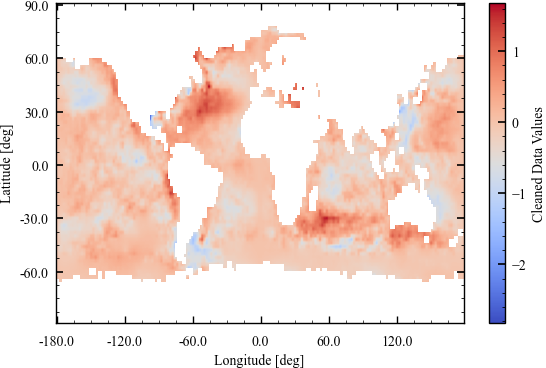

In [108]:
plt.imshow(x_tilde.reshape((90,180,360))[:,:,0], cmap='coolwarm', aspect='auto')

plt.colorbar(label='Cleaned Data Values')

plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')

plt.xticks(np.arange(0, 180, 30), lon_str[::30])
plt.yticks(np.arange(0, 90, 15), lat_str[::15])

plt.savefig('figs/lab0/cleaned_data.png', dpi=300, bbox_inches='tight')


In [19]:
cov = np.ma.dot(x_tilde, x_tilde.T) / (x_tilde.shape[1] - 1)

In [20]:
from numpy.linalg import eig
eig_vals, eig_vecs = eig(cov)

In [21]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

In [22]:
# Explained variance
explained_variance = eig_vals_sorted / np.sum(eig_vals_sorted)

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

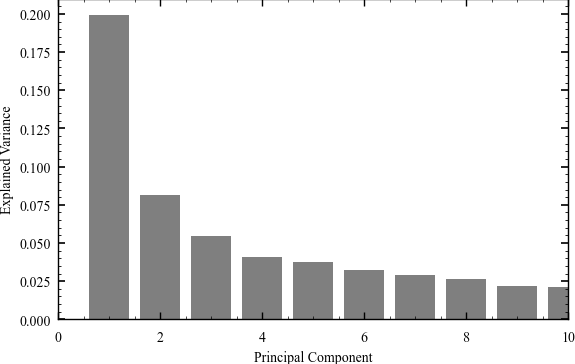

In [110]:
# Plot explained variance as a bar
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
# plt.title('Explained Variance')

plt.xlim(0, 10)
plt.savefig('figs/lab0/explained_variance.png', dpi=300, bbox_inches='tight')

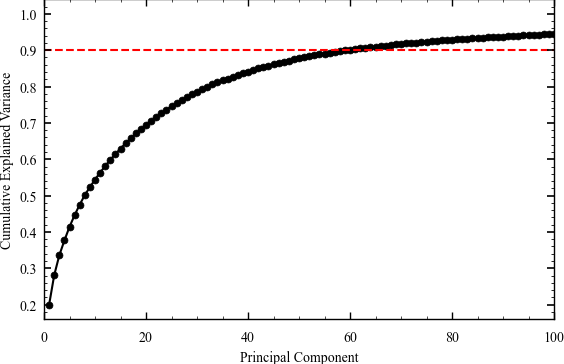

In [111]:
# Plot cumulative explained variance as a line
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o', color='k', label='Cumulative explained variance')
plt.axhline(y=0.9, color='r', linestyle='--', label=r'90% Explained Variance')

plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
# plt.title('Cumulative Explained Variance')

plt.xlim(0, 100)
plt.savefig('figs/lab0/cumulative_explained_variance.png', dpi=300, bbox_inches='tight')

### Map first EOF

In [37]:
def plot_masked_array(data, mask):
    vmin = np.percentile(data, 1)
    vmax = np.percentile(data, 99)
    masked_p_data = np.ma.masked_array(data, mask)
    plt.imshow(masked_p_data, cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

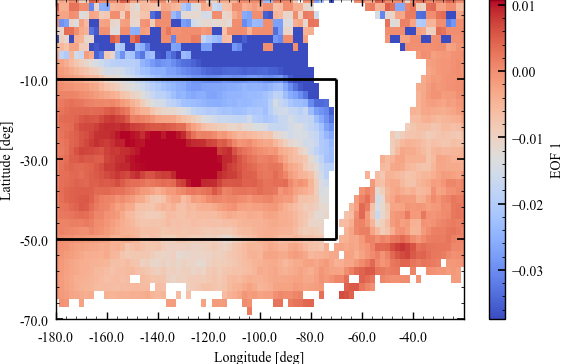

In [92]:
plot_masked_array(np.real(eig_vecs_sorted[:,0].reshape((90,180))), mask[:,0])
plt.colorbar(label='EOF 1')
# Create a box around ENSO
plt.xlim(0,80)
plt.ylim(80,40)
plt.hlines([50,70], 0, 55, colors='k', lw=2)
plt.vlines(55, 50, 70, colors='k', lw=2)

plt.xticks(np.arange(0, 80, 10), lon_str[np.arange(0, 80, 10)])
plt.yticks(np.arange(80, 40, -10), lat_str[np.arange(80, 40, -10)])
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.savefig('figs/lab0/EOF1.png', dpi=300, bbox_inches='tight')

### Project Eigenvalues onto data

In [75]:
# Project the data onto the first EOF
A = np.ma.dot(eig_vecs_sorted.T, x_tilde)

/Users/shockblack/opt/anaconda3/envs/py312/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/shockblack/opt/anaconda3/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


Text(0, 0.5, 'PC1')

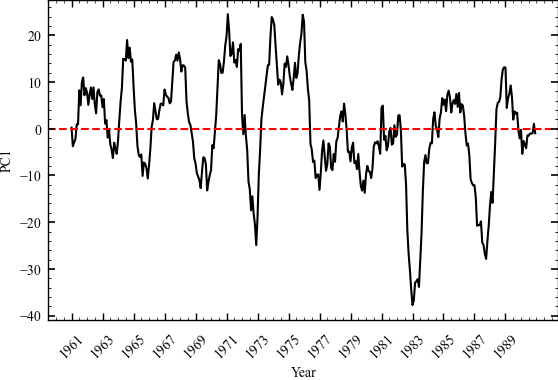

In [95]:
# Time series of the first EOF
plt.plot(A[0,:])
# X axis given by headers array
plt.xticks(np.arange(0, 360, 24), headers[::24,2], rotation=45)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Year')
plt.ylabel('PC1')
# plt.savefig('figs/lab0/PC1.png', dpi=300, bbox_inches='tight')

/Users/shockblack/opt/anaconda3/envs/py312/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/shockblack/opt/anaconda3/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/shockblack/opt/anaconda3/envs/py312/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/shockblack/opt/anaconda3/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/shockblack/opt/anaconda3/envs/py312/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the im

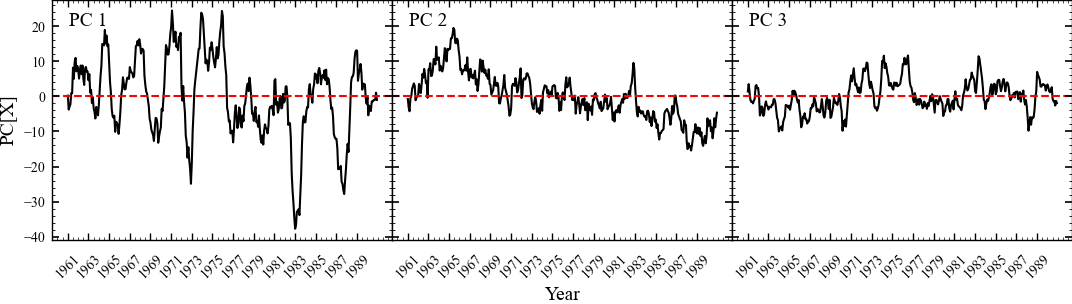

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True)
# remove whitespace between subplots
plt.subplots_adjust(wspace=0.0)

# Plot the first 3 EOFs
for i, ax in enumerate(axes.flatten()):
    ax.plot(A[i,:])
    ax.text(0.05, 0.95, f'PC {i+1}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xticks(np.arange(0, 360, 24), headers[::24,2], rotation=45)
    if i == 0:
        ax.set_ylabel('PC[X]', fontsize=14)
    elif i == 1:
        ax.set_xlabel('Year', fontsize=14)

plt.savefig('figs/lab0/PCs.png', dpi=300, bbox_inches='tight')
